In [54]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import warnings
from scipy import stats
import math
from IPython.core.debugger import Pdb
ipdb = Pdb()

In [55]:
sys.path.append('/Users/danieldaylewis/Documents/code/')
from Vape.utils import utils_funcs as uf

In [56]:
class SimulateDataFa:
    def __init__(self, L, Ph, mu):
        self.L = L 
        self.Ph = Ph
        self.mu = mu
    
    def simulate(self, N):
        x_dim, z_dim = self.L.shape
        Z = np.random.normal(size=(z_dim, N))
        ns = np.multiply(np.random.normal(size=(x_dim, N)).T, np.sqrt(self.Ph)).T
        X = np.add((np.dot(self.L, Z) + ns).T, self.mu)
        X = X.T
        return X

In [57]:
def rcond(X):
    ''' Inverse of the condition number 
    condition number = ratio of largest to smallest singular value'''
    return 1 / np.linalg.cond(X)

In [58]:
def indep_gauss_fit(X):
    estim_params = {}
    estim_params['Ph'] = np.var(X, axis=1)
    estim_params['d'] = np.mean(X, axis=1)
    return estim_params

In [59]:
def fastfa(X, z_dim, typ='fa', tol=1e-8, cyc=1e8, min_var_frac=0.01, verbose=False, debug=False):
    
    x_dim, N = X.shape
    
    # I think this is the same as cov(X', 1) but keep an eye
    cX = np.cov(X, ddof=0)
    
    # Is covariance matrix full rank?
    if np.linalg.matrix_rank(cX) == x_dim: 
        scale = np.exp(2*np.sum(np.log(np.diag(np.linalg.cholesky(cX))))/ x_dim)
    else:
        warnings.warn('Data matrix is not full rank')
        r = np.linalg.matrix_rank(cX)
        eig_vals, _ = np.linalg.eig(cX)
        # Sometimes returns negligable imaginary component
        e = np.sort(eig_vals)[::-1].real
        scale = stats.mstats.gmean(e[0:r])
    
    if not debug:
        L = np.random.normal(size=(x_dim, z_dim)) * np.sqrt(scale/z_dim)
    else:
        L = np.ones((x_dim, z_dim)) * np.sqrt(scale/z_dim)
        warnings.warn('DEBUGGING MODE ON')
    
    Ph = np.diag(cX)
    d = np.mean(X, 1)
    
    var_floor = min_var_frac * np.diag(cX)
    
    I = np.identity(z_dim)
    const = -x_dim / 2*np.log(2*math.pi)
    LLi = 0
    LL = []
    
    for i in range(int(cyc)):
        # E-step
        iPh = np.diag(1/Ph)
        iPhL = iPh @ L
        # Numpy does not automatically deal with matrix right side division
        # so have to invert the square matrix denominator by hand
        MM   = iPh - (iPhL @ np.linalg.inv(I + L.T @ iPhL)) @ iPhL.T
        beta = L.T @ MM  # zDim x xDim
        cX_beta = np.dot(cX, beta.T)  # xDim x zDim
        EZZ = I - np.dot(beta, L) + np.dot(beta, cX_beta)
        
        # Compute log likelihood
        LLold = LLi;    
        ldM   = np.sum(np.log(np.diag(np.linalg.cholesky(MM))))
        LLi   = N*const + N*ldM - 0.5*N*np.sum(np.sum(MM * cX))
        if verbose:
            print(f'EM iteration {i} lik {LLi}')
        
        LL = np.hstack((LL, LLi))
        
        L  = cX_beta @ np.linalg.inv(EZZ)
        
        Ph = np.diag(cX) - np.sum(cX_beta * L, 1)
        if typ ==  'ppca':
            Ph = mean(Ph) * np.ones(x_dim, 1)
            
        elif typ == 'fa':
            # Set minimum private variance
            Ph = np.maximum(var_floor, Ph)
            
        if i<=2:
            LLbase = LLi
#         elif True:
#             1/0
        elif LLi < LLold:
            print('VIOLATION')
        elif LLi-LLbase < (1+tol)*(LLold-LLbase):
            break
    
    
    if any(Ph == var_floor):
        warnings.warn('Private variance floor used for one or more observed dimensions in FA');

    estim_params = {}
    
    # The Value of L is very slightly different to matlab version (correct up to 4.s.f)
    # not sure whether to care or not
    estim_params['L'] = L;
    estim_params['Ph'] = Ph;
    estim_params['d'] = d;
    
    return estim_params



In [60]:
def remove_zero_var_dims(A):
    dim_keep = np.var(A, axis=1)!=0
    A = A[dim_keep, :]
    if any(~dim_keep):
        warnings.warn('Removing observed dimension(s) showing zero training variance')
    return A

In [61]:
def fastfa_estep(X, params):
    
    x_dim = X.shape[0]
    
    try:
        N = X.shape[1]
    except IndexError:
        N = 1
        
    try:
        z_dim = params['L'].shape[1]
    except IndexError:
        z_dim = 1
    
    L = params['L']
    Ph = params['Ph']
    d = params['d']
    
    Xc = np.subtract(X.T, d)
    XcXc = Xc.T @ Xc
    
    I = np.identity(z_dim)
    
    const = -x_dim/2 * np.log(2*math.pi)
    
    iPh  = np.diag(1/Ph)
    iPhL = iPh @ L
    
    # Make iPhL behave as a vector if it is 1-dimensional
    if len(iPhL.shape) == 1:
        iPhL = iPhL.reshape(len(iPhL), 1)  
        
    MM = iPh - (iPhL @ np.linalg.inv(I + L.T @ iPhL)) @ iPhL.T
    beta = L.T @ MM  # zDim x xDim

    Z = {}
    Z['mean'] = beta @ Xc.T  # zDim x N
    Z['cov'] = I - beta @ L  # zDim x zDim; same for all observations
    LL = N*const + 0.5*N*np.log(np.linalg.det(MM)) - 0.5 * np.sum(np.sum(MM * XcXc))
    
    return Z, LL

In [72]:
def cosmoother_fa(Y, params):
  
    L  = params['L']
    L = np.flip(L, axis=1)
    Ph = params['Ph']
    d  = params['d']

    y_dim = L.shape[0]
    
    try:
        x_dim = L.shape[1]
    except IndexError:  # L is a vector
        x_dim = 1
        L = L.reshape(len(L), 1)
    
    I = np.identity(x_dim)

    Ycs = np.zeros(Y.shape)
    Vcs = np.zeros(y_dim)

    for i in range(y_dim):
        
        mi = np.delete(np.arange(y_dim), i)
        
        Phinv  = 1/Ph[mi]  # (y_dim-1) x 1
        
        # I think the tile function is right but keep an eye
#         LRinv  = (L[mi,:].T * np.tile(Phinv, x_dim)).T # x_dim x (y_dim - 1)
        LRinv  = (L[mi,:] * np.tile(Phinv, (x_dim, 1)).T).T # x_dim x (y_dim - 1)
        LRinvL = LRinv @ L[mi,:]  # x_dim x x_dim
#         ipdb.set_trace()
        
        term2 = np.matrix(L[i,:]) @ (I - LRinvL @ np.linalg.inv(I + LRinvL)) # 1 x x_dim

        dif = np.subtract(Y[mi, :].T, d[mi])
        Ycs[i,:] = d[i] + term2 @ LRinv @ dif.T
        Vcs[i] = L[i,:]@L[i,:].T + Ph[i] - term2 @ LRinvL @ L[i,:].T

#     ipdb.set_trace()
    return Ycs, Vcs


In [63]:
def crossvalidate_fa(X, debug=False, show_plots=True):
    
    num_folds  = 4
    z_dim_list  = range(1,11)
    show_plots = True
    verbose   = False
    
    [x_dim, N] = X.shape;
    
    if not debug:
        # Randomly reorder data points
        [np.random.shuffle(row) for row in X]
    else:
        warnings.warn('Debugging mode on')
    
    fdiv = np.floor(np.linspace(1, N+1, num_folds+1))
    
    # Matlab code removes dims for every z_dim and test/train split,
    # but i think you only need to do this once? Could cause bugs in future
    X = remove_zero_var_dims(X)
    
    dims = []
    for i, z_dim in enumerate(z_dim_list):
        
        print(f'Processing latent dimensionality {z_dim}')
        dim = {}
        dim['z_dim'] = z_dim
        dim['sumPE'] = 0
        dim['sumLL'] = 0

        if rcond(np.cov(X).T) < 1e-8:
            warnings.warn('Training data covariance matrix ill-conditioned')
        
        # Split X into test and train 
        kf = KFold(n_splits=4, shuffle=False)  # Order is not shuffled in matlab version
        cvf = 0
        
        for train_idx, test_idx in kf.split(X.T):
            cvf += 1
            print(f'Cross validation fold {cvf}')
            
            X_train = X[:, train_idx]
            X_test = X[:, test_idx]
            
            estim_params = fastfa(X_train, z_dim, min_var_frac=-np.inf, debug=debug)
            
            if z_dim == 0:
                raise NotImplementedError('Not ported indepGaussEval yet')
                LL, sse = indepGaussEval(Xtest, estim_params)
            else:
                blah, LL = fastfa_estep(X_test, estim_params)
                # One result different to matlab but only to very high precision
                Xcs, _ = cosmoother_fa(X_test, estim_params);     
                sse = np.sum((np.squeeze(Xcs) - X_test)**2)
                
            dim['sumPE'] = dim['sumPE'] + sse;
            dim['sumLL'] = dim['sumLL'] + LL;
        
        dims.append(dim)
    
    sumPE = [dim['sumPE'] for dim in dims]
    plt.plot(z_dim_list, sumPE)
    
    
    


/Users/danieldaylewis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Debugging mode on
  
/Users/danieldaylewis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: DEBUGGING MODE ON


Processing latent dimensionality 1
Cross validation fold 1
Cross validation fold 2
Cross validation fold 3
Cross validation fold 4
Processing latent dimensionality 2
Cross validation fold 1
Cross validation fold 2
Cross validation fold 3
Cross validation fold 4
Processing latent dimensionality 3
Cross validation fold 1
Cross validation fold 2
Cross validation fold 3
Cross validation fold 4
Processing latent dimensionality 4
Cross validation fold 1
Cross validation fold 2
Cross validation fold 3
Cross validation fold 4
Processing latent dimensionality 5
Cross validation fold 1
Cross validation fold 2
Cross validation fold 3
Cross validation fold 4
Processing latent dimensionality 6
Cross validation fold 1
Cross validation fold 2
Cross validation fold 3
Cross validation fold 4
Processing latent dimensionality 7
Cross validation fold 1
Cross validation fold 2
Cross validation fold 3
Cross validation fold 4
Processing latent dimensionality 8
Cross validation fold 1
Cross validation fold 2


TypeError: 'NoneType' object is not subscriptable

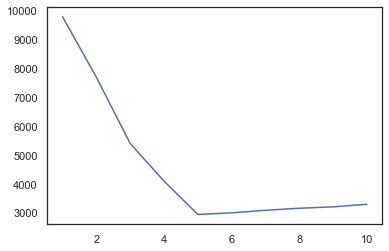

In [73]:
### EXAMPLE #####
n_dims = 20
L = np.random.normal(size=(n_dims,5))
Ph = np.linspace(0.1, 2, n_dims)
mu = np.ones((n_dims))

# simdata = SimulateDataFa(L, Ph, mu)
# X = simdata.simulate(100)
# X = np.array([1,2,3,4,0,2,2,0,1,0,3,0,0,1,0,4])
# X = X.reshape((4,4))

test_case_path = '/Users/danieldaylewis/Documents/code/SpatialNeuronNet/fa_Yu/test_case.mat'
lm = uf.LoadMat(test_case_path)
X = lm.dict_['X']

crossvalidate_fa(X, debug=True)

Z, LL = fastfa_estep(X, params)

In [ ]:
def crossvalidate_fa_bak(X, debug=False):
    
    num_folds  = 4
    z_dim_list  = range(1,11)
    show_plots = True
    verbose   = False
    
    [x_dim, N] = X.shape;
    
    if not debug:
        # Randomly reorder data points
        [np.random.shuffle(row) for row in X]
    else:
        warnings.warn('Debugging mode on')
    
    fdiv = np.floor(np.linspace(1, N+1, num_folds+1))
    
    # Matlab code removes dims for every z_dim and test/train split,
    # but i think you only need to do this once? Could cause bugs in future
    X = remove_zero_var_dims(X)
    
    dims = []
    for i, z_dim in enumerate(z_dim_list):
        
        print(f'Processing latent dimensionality {z_dim}')
        dim = {}
        dim['z_dim'] = z_dim
        dim['sumPE'] = 0
        dim['sumLL'] = 0

        if rcond(np.cov(X).T) < 1e-8:
            warnings.warn('Training data covariance matrix ill-conditioned')
        
        # Train on all data
        if z_dim == 0:
            # If you want a 0 latent dimensional model
            dim['estim_params'] = ind_gauss_fit(X)
        else:
            # Run factor analysis
            print(f'z_dim {z_dim}, X.shape {X.shape}')
            dim['estim_params'] = fastfa(X, z_dim, min_var_frac=-np.inf, debug=debug)
        
        # Split X into test and train 
        kf = KFold(n_splits=4, shuffle=False)  # Order is not shuffled in matlab version
        
        cross_validation_fold = 0
        for train_idx, test_idx in kf.split(X.T):
            cross_validation_fold += 1
            X_train = X[:, train_idx]
            X_test = X[:, test_idx]
            
            if z_dim == 0:
                raise NotImplementedError('Not ported indepGaussEval yet')
                LL, sse = indepGaussEval(Xtest, dim['estim_params'])
            else:
                blah, LL = fastfa_estep(X_test, dim['estim_params'])
                
                # One result different to matlab but only to very high precision
                Xcs, _ = cosmoother_fa(X_test, dim['estim_params']);     
                sse = np.sum((np.squeeze(Xcs) - X_test)**2)
                
            dim['sumPE'] = dim['sumPE'] + sse;
            dim['sumLL'] = dim['sumLL'] + LL;
        
        dims.append(dim)
